In [1]:
import sketch
import pandas as pd

In [2]:
try:
    df = pd.read_parquet('dtp.parquet')
except:
    from tqdm import tqdm
    import json
    
    files = ['khabarovskii-krai.geojson', 'evreiskaia-avtonomnaia-oblast.geojson', 'amurskaia-oblast.geojson', 'sakhalinskaia-oblast.geojson']
    columns = ['datetime', 'lat', 'lon', 'parent_region', 'region', 'address', 'category', 'severity', 'vehicles', 'participant_categories', 'participants_count', 'injured_count', 'dead_count', 'light', 'weather']

    def get_df(dtp_geojson):
        
        # print(dtp_geojson)
        with open(dtp_geojson) as json_file:
            df = pd.DataFrame(json.load(json_file)['features']).drop(['type', 'geometry'], axis=1)

        single_value_keys = ['datetime', 'parent_region', 'region', 'address', 'category', 'severity', 'participants_count', 'injured_count', 'dead_count', 'light']

        # tqdm.pandas(desc='coordinates')
        df[['lat','lon']] = df.properties.apply(lambda x: pd.Series([x['point']['lat'], x['point']['long']]))
        
        # tqdm.pandas(desc='single value keys')
        df[single_value_keys] = df.properties.apply(lambda x: pd.Series(x[key] for key in single_value_keys))

        # tqdm.pandas(desc='weather')
        df['weather'] = df.properties.apply(lambda x: ', '.join(x['weather']))

        # tqdm.pandas(desc='participant_categories')
        def get_participant_categories(x):
            res = sorted(x['participant_categories'])
            res.insert(0, res.pop(res.index('Все участники')))
            return ', '.join(res).replace('Все участники','Водители и пассажиры ТС')
        df['participant_categories'] = df.properties.apply(get_participant_categories)

        # tqdm.pandas(desc='vehicles')
        df['vehicles'] = df.properties.apply(lambda x: [' '.join([str(v['brand']), str(v['model']), str(v['year'])]) for v in x['vehicles']])
        
        df = df[(df.lon > 119) & (df.lon < 157) & (df.lat > 46) & (df.lat < 62)]
        df.datetime = df.datetime.astype('datetime64')
        return df[columns]

    df = pd.DataFrame(columns=columns)
    pbar = tqdm(files)
    for f in pbar:
        pbar.set_postfix_str(f)
        df = pd.concat([df, get_df(f)], ignore_index=True)

    # df.to_csv('dtp.csv', sep=';', index=False)
    df.to_parquet('dtp.parquet')

df.info()
df.sample(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30662 entries, 0 to 30661
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   datetime                30662 non-null  datetime64[ns]
 1   lat                     30662 non-null  float64       
 2   lon                     30662 non-null  float64       
 3   parent_region           30662 non-null  object        
 4   region                  30662 non-null  object        
 5   address                 28908 non-null  object        
 6   category                30662 non-null  object        
 7   severity                30662 non-null  object        
 8   vehicles                30662 non-null  object        
 9   participant_categories  30662 non-null  object        
 10  participants_count      30662 non-null  int64         
 11  injured_count           30662 non-null  int64         
 12  dead_count              30662 non-null  int64 

,datetime,lat,lon,parent_region,region,address,category,severity,vehicles,participant_categories,participants_count,injured_count,dead_count,light,weather
24638,2018-09-25 17:33:00,50.305747,127.531904,Амурская область,Благовещенск,"г Благовещенск, ш Новотроицкое, 21А",Наезд на пешехода,Легкий,[TOYOTA Прочие модели грузовых Toyota 1986],"Водители и пассажиры ТС, Пешеходы",2,1,0,Светлое время суток,Ясно
10877,2020-08-16 19:37:00,48.488446,135.042443,Хабаровский край,Хабаровск,"г Хабаровск, ул Тихоокеанская, 16 1",Столкновение,Тяжёлый,"[TOYOTA Camry 2014, HONDA CBR 2004]","Водители и пассажиры ТС, Мотоциклисты",2,1,0,Светлое время суток,Ясно
29394,2015-07-03 17:30:00,46.935274,142.745126,Сахалинская область,Южно-Сахалинск,"г Южно-Сахалинск, ул Пуркаева М.А., 106-1",Наезд на пешехода,Легкий,[Прочие марки ТС Прочие марки и модели ТС None],"Водители и пассажиры ТС, Пешеходы",2,1,0,Светлое время суток,Пасмурно
9230,2019-03-19 01:30:00,48.461112,135.119927,Хабаровский край,Хабаровск,"г Хабаровск, пр-кт 60-летия Октября, Океанская 21",Наезд на препятствие,С погибшими,[NISSAN Teana 2003],Водители и пассажиры ТС,2,1,1,"В темное время суток, освещение включено",Ясно


### `.ask` the questions

In [16]:
df.sketch.ask('Опиши датасет')

Failed to use remote https://prompts.approx.dev.. 414 Client Error: Request-URI Too Large for url: https://prompts.approx.dev/prompt/ask_from_parts?dfname=df&column_names=WyJpbmRleCIsICJkYXRldGltZSIsICJsYXQiLCAibG9uIiwgInBhcmVudF9yZWdpb24iLCAicmVnaW9uIiwgImFkZHJlc3MiLCAiY2F0ZWdvcnkiLCAic2V2ZXJpdHkiLCAidmVoaWNsZXMiLCAicGFydGljaXBhbnRfY2F0ZWdvcmllcyIsICJwYXJ0aWNpcGFudHNfY291bnQiLCAiaW5qdXJlZF9jb3VudCIsICJkZWFkX2NvdW50IiwgImxpZ2h0IiwgIndlYXRoZXIiXQ%3D%3D&data_types=WyJpbnQ2NCIsICJkYXRldGltZTY0W25zXSIsICJmbG9hdDY0IiwgImZsb2F0NjQiLCAib2JqZWN0IiwgIm9iamVjdCIsICJvYmplY3QiLCAib2JqZWN0IiwgIm9iamVjdCIsICJvYmplY3QiLCAib2JqZWN0IiwgImludDY0IiwgImludDY0IiwgImludDY0IiwgIm9iamVjdCIsICJvYmplY3QiXQ%3D%3D&extras=W3sicm93cyI6IDMwNjYyLCAiY291bnQiOiAzMDY2MiwgInVuaXFlY291bnQiOiAzMDY2MiwgImhlYWQtc2FtcGxlIjogIlsnMCcsICcxJywgJzInLCAnMycsICc0J10iLCAicXVhbnRpbGVzIjogIlswLjAsIDc2NjUuMjUsIDE1MzMwLjUsIDIyOTk1Ljc1LCAzMDY2MS4wXSJ9LCB7InJvd3MiOiAzMDY2MiwgImNvdW50IjogMzA2NjIsICJ1bmlxZWNvdW50IjogMzAwNTksICJoZWFkLXNhbXBsZ

In [55]:
df.sketch.ask("Какие колонки есть в датасете?")

In [3]:
address = df.pop('address')
df.sketch.ask('Опиши датасет')

In [5]:
df.parent_region.value_counts()

Хабаровский край                14362
Амурская область                 9546
Сахалинская область              5017
Еврейская автономная область     1737
Name: parent_region, dtype: int64

In [6]:
df.sketch.ask("Какие географические данные есть в датасете?")

In [7]:
df.sketch.ask("Какие уникальные значения у столбцов category, severity?")

In [8]:
print(f'Уникальные значения category\n{df.category.unique()}')
print(f'Уникальные значения severity\n{df.severity.unique()}')

Уникальные значения category
['Отбрасывание предмета' 'Столкновение' 'Наезд на стоящее ТС'
 'Наезд на пешехода' 'Опрокидывание' 'Наезд на велосипедиста'
 'Съезд с дороги' 'Иной вид ДТП' 'Наезд на препятствие'
 'Наезд на внезапно возникшее препятствие' 'Падение пассажира'
 'Наезд на животное'
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ'
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность'
 'Падение груза'
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы']
Уникальные значения severity
['Легкий' 'Тяжёлый' 'С погибшими']


In [ ]:
df.sketch.ask('Какие минимальные и максимальные, средние и медианные значения у численных столбцов?')

In [ ]:
df.describe()

,lat,lon,participants_count,injured_count,dead_count
count,30662.000000,30662.000000,30662.000000,30662.000000,30662.000000
mean,49.445560,134.289527,2.426424,1.262214,0.104135
std,1.795554,5.275187,1.165527,0.899246,0.368720
min,46.004200,120.166667,1.000000,0.000000,0.000000
25%,48.422789,128.481935,2.000000,1.000000,0.000000
50%,48.971184,135.078009,2.000000,1.000000,0.000000
75%,50.514203,137.004433,3.000000,1.000000,0.000000
max,60.087426,156.143100,58.000000,43.000000,15.000000


#### Ещё некоторые примеры

In [18]:
df.sketch.ask('Как определить долю иномарок среди автомобилей?')

In [52]:
df.sketch.ask("Какие уникальные значения строковых столбцов?")

In [53]:
df.sketch.ask('Как построить гистограмму количества пострадавших?')

In [54]:
df.sketch.ask("Какие значения и содержатся в столбце light")

In [58]:
df.sketch.ask("Сколько ДТП с участием пешеходов")

In [57]:
df.sketch.ask("Сколько ДТП произошло в тёмное время суток и в светлое время суток?")
df.light.value_counts()

Светлое время суток                            19465
В темное время суток, освещение включено        6362
В темное время суток, освещение отсутствует     3876
Сумерки                                          643
В темное время суток, освещение не включено      313
Не установлено                                     3
Name: light, dtype: int64

In [61]:
df.sketch.ask("Сколько ДТП с пострадавшими?")
df.sketch.ask("Сколько строк со значением `injured_count` больше 0?")
df.sketch.ask("How many rows with `injured_count` greater than 0?")
print('ДТП с пострадавшими:', (df.injured_count > 0).sum())

ДТП с пострадавшими: 28915


### `.howto` write the code

#### Генерация признаков

In [ ]:
df.sketch.howto('Сгенерируй новые признаки')

In [ ]:
df.drop('datetime',axis=1).sketch.howto('Сгенерируй новые признаки')

In [ ]:
df.datetime = df.datetime.astype(str)
df.sketch.howto('Сгенерируй новые признаки')

In [ ]:
df.sketch.howto('Сгенерируй новые признаки (поле datetime необходимо перевести из строки в datetime64)')

In [ ]:
print(df.weather.unique())

['Ясно' 'Дождь' 'Пасмурно' 'Снегопад' 'Метель' 'Пасмурно, Дождь'
 'Ясно, Туман' 'Пасмурно, Снегопад' 'Снегопад, Метель' 'Дождь, Снегопад'
 'Туман' 'Дождь, Ураганный ветер' 'Туман, Температура ниже -30С'
 'Пасмурно, Туман' 'Ясно, Температура ниже -30С' 'Дождь, Туман'
 'Снегопад, Температура ниже -30С' 'Пасмурно, Температура ниже -30С'
 'Ясно, Дождь' 'Ясно, Температура выше +30С' 'Пасмурно, Метель'
 'Пасмурно, Ураганный ветер' 'Пасмурно, Температура выше +30С'
 'Метель, Ураганный ветер']


In [ ]:
df.sketch.howto('Сгенерируй новые логические признаки из всех возможных погодных условий в поле `weather` (сначала приведи значения к нижнему регистру)')

In [ ]:
df.sketch.howto('Сгенерируй новые логические признаки из всех возможных погодных условий в поле `weather` (погодные условия перечисляются через запятую)')

In [ ]:
df1 = df.copy()
# Create a list of all possible weather conditions
weather_conditions = df['weather'].str.split(', ').tolist()
weather_conditions = [item for sublist in weather_conditions for item in sublist]
weather_conditions = list(set(weather_conditions))

# Create new boolean columns for each weather condition
for condition in weather_conditions:
    df1[condition] = df['weather'].str.contains(condition).astype(int)
    
df1[weather_conditions].sample(5)

,Температура выше +30С,Ясно,Дождь,Температура ниже -30С,Пасмурно,Снегопад,Туман,Метель,Ураганный ветер
11106,0,0,0,0,1,0,0,0,0
4025,0,1,0,0,0,0,0,0,0
25534,0,0,0,0,0,1,0,0,0
24867,0,1,0,0,0,0,0,0,0
22514,0,1,0,0,0,0,0,0,0


#### Манипуляции с данными

In [75]:
df.vehicles.sample(5)

150                           [None None None]
29443                      [TOYOTA Vista 1990]
2725                         [HONDA Logo 1999]
25595    [NISSAN Juke 1994, NISSAN Tiida 2009]
6093      [TOYOTA Crown 2002, YAMAHA XVS 2003]
Name: vehicles, dtype: object

In [63]:
df.sketch.ask('Какой минимальный и максимальный годы выпуска автомобилей (колонка vehicles имеет тип списка, год может быть неизвестен)?')

In [80]:
df.sketch.howto('Определи минимальный и максимальный годы выпуска автомобилей (колонка vehicles имеет тип списка, год может быть неизвестен)?')

In [ ]:
# Get list of all vehicles
vehicles_list = df['vehicles'].tolist()

# Create empty list to store all years
years_list = []

# Iterate through the list of vehicles and extract the year from each vehicle
for vehicles in vehicles_list:
    for v in vehicles:
        # Split the string on space to get the year
        year = v.split(' ')[-1]
        # Append the year to the list of years
        if year.isdigit():
            years_list.append(int(year))
        
# Calculate min and max years from the list of years
min_year = min(years_list)
max_year = max(years_list)

print('Min Year:', min_year)
print('Max Year:', max_year)

Min Year: 1
Max Year: 2022


In [91]:
df.sketch.howto("""
    Посчитать количество ДТП с участием машин марки `TOYOTA` до 2000 года выпуска,
    поле `vehicles` имеет тип списка, год может быть неизвестен
""")

In [93]:
# Count the number of accidents involving Toyota vehicles before 2000
toyota_before_2000 = df[df['vehicles'].apply(lambda x: any('TOYOTA' in v and (int(v.split()[-1]) < 2000 if v.split()[-1].isdigit() else False) for v in x))].shape[0]
print(f'Number of accidents involving Toyota vehicles before 2000: {toyota_before_2000}')

Number of accidents involving Toyota vehicles before 2000: 8961


In [97]:
df.sketch.howto("""
    Количество ДТП с участием машин марки `TOYOTA` до 2000 года выпуска,
    поле `vehicles` имеет тип списка, год может быть неизвестен
""")

In [98]:
df.sketch.howto('Количество ДТП с участием мотоциклистов')

In [111]:
# Count the number of accidents involving motorcyclists
motorcycle_accidents = df[df['participant_categories'].str.contains('Мотоциклисты')].shape[0]
print(f'Number of accidents involving motorcyclists: {motorcycle_accidents}')

Number of accidents involving motorcyclists: 2221


In [15]:
df.sketch.howto('Какая фаза луны была в день ДТП?')

In [17]:
df.sketch.howto('На каком расстоянии от Москвы произошло ДТП?')

In [112]:
# import necessary libraries
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# define coordinates of Moscow
moscow_lat = 55.755826
moscow_lon = 37.6173

# calculate distance from Moscow for each row in the dataframe
df['distance_from_moscow'] = df.apply(lambda row: geodesic((row['lat'], row['lon']), (moscow_lat, moscow_lon)).km, axis=1)

# print the min and max distances from Moscow
print('Minimum distance from Moscow:', df['distance_from_moscow'].min())
print('Maximum distance from Moscow:', df['distance_from_moscow'].max())

Minimum distance from Moscow: 4737.977084020733
Maximum distance from Moscow: 7127.686149630483


In [110]:
df.sketch.howto('Сколько ДТП произошли в день рождения Ленина?')

In [102]:
df.sketch.ask('День рождения Ленина')

In [103]:
df.sketch.howto('День рождения Ленина')

#### Графики

In [121]:
df.sketch.howto("""Построить гистограмму количества пострадавших, 
                установить количество корзин равным максимальному значению""")

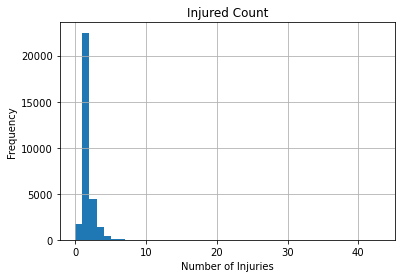

In [5]:
import matplotlib.pyplot as plt

# Get the max value of injured_count
max_injured_count = df['injured_count'].max()

# Create a histogram of the injured_count column with max_injured_count bins
df['injured_count'].hist(bins=max_injured_count)

# Set the title and labels for the histogram
plt.title('Injured Count')
plt.xlabel('Number of Injuries')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [13]:
df.drop('vehicles',axis=1).sketch.howto("""Построй координаты на графике с помощью seaborn 
    Цветом обозначь разные `parent_region`, 
    размер графика 12 на 9, размер точек пропорционально `participants_count`,
    подпиши названия осей и графика, добавь на график сетку,
    прозрачность точек 30 процентов""")

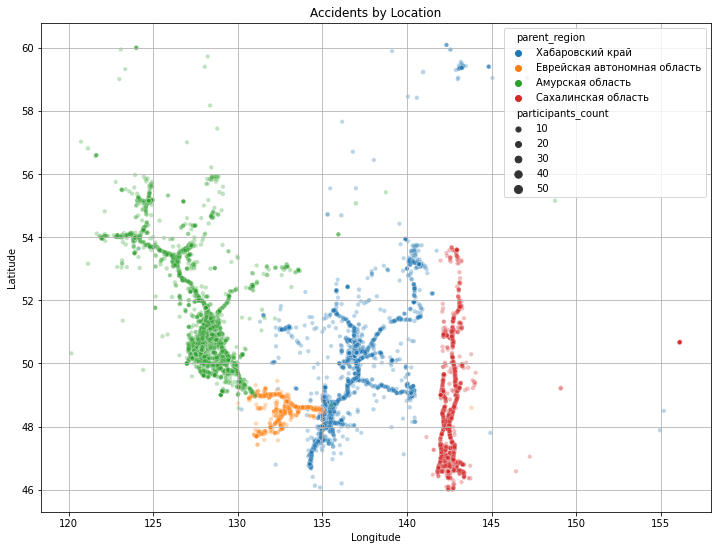

In [14]:
import seaborn as sns

# Set figure size
plt.figure(figsize=(12, 9))

# Plot the data
sns.scatterplot(x="lon", y="lat", hue="parent_region", size="participants_count", data=df, alpha=0.3)

# Add labels and grid
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Accidents by Location')
plt.grid(True)

Text(0, 0.5, 'Latitude')

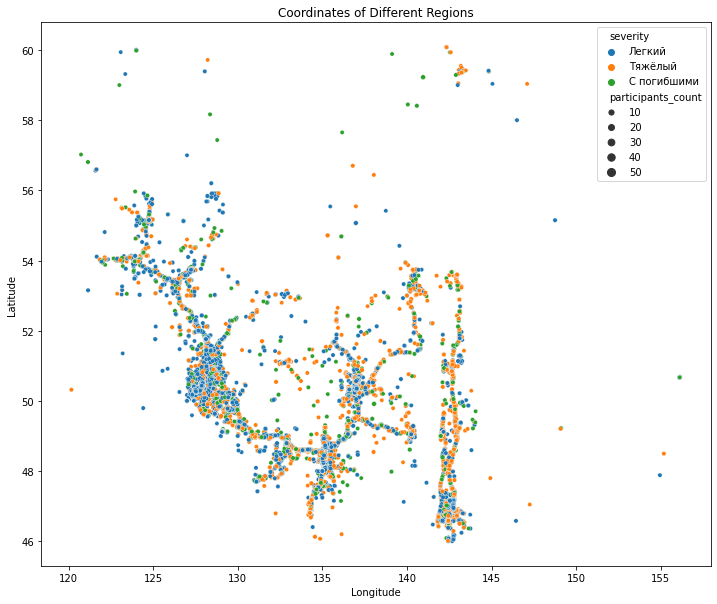

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(12, 10))

# Plot the data
sns.scatterplot(x="lon", y="lat", hue="severity", size="participants_count", data=df)

# Add labels and title
plt.title("Coordinates of Different Regions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [15]:
df.sketch.howto('Кластеризация точек')

In [17]:
df.sketch.howto("""Построить модель, 
    предсказывающую количество погибших в ДТП на основе численных признаков""")

In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#separate the dataframe into features and target variables
X = df[['lat', 'lon', 'participants_count', 'injured_count']]
y = df['dead_count']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit the model to the training data
model = LinearRegression()
model.fit(X_train, y_train)

#make predictions on the test data
y_pred = model.predict(X_test)

#evaluate the model's performance using metrics such as mean squared error and r2 score
mse = mean_squared_error(y_test, y_pred) 
r2 = r2_score(y_test, y_pred) 
print('Mean Squared Error:', mse) 
print('R2 Score:', r2) 